# Preparing the libraries and modules
---

In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0

import matplotlib.pyplot as plt
import numpy as np

IMG_SIZE = 224
BATCH_SIZE = 32

In [ ]:
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

In [ ]:
dataset_name = "stanford_dogs"
(ds_train, ds_test), ds_info = tfds.load(
    dataset_name, split=["train", "test"], with_info=True, as_supervised=True
)
NUM_CLASSES = ds_info.features["label"].num_classes

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/incomplete.ZWNFNL_0.2.0/stanford_dogs-train.tfrecord*...:   …

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/incomplete.ZWNFNL_0.2.0/stanford_dogs-test.tfrecord*...:   0…

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [ ]:
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))

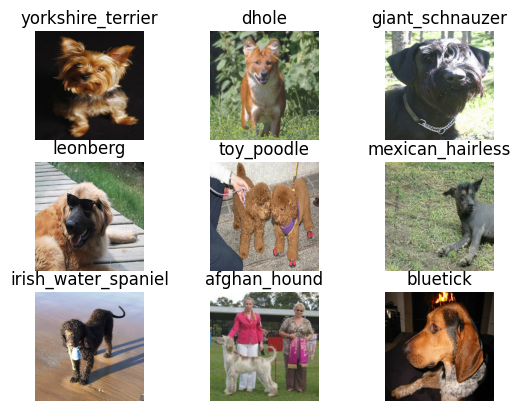

In [ ]:
# Plotting the dataset also with the labels
def format_label(label):
  string_label = label_info.int2str(label)
  return string_label.split("-")[1]

label_info = ds_info.features["label"]
for i, (image, label) in enumerate(ds_train.take(9)):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image.numpy().astype("uint8"))
  plt.title("{}".format(format_label(label)))
  plt.axis("off")

In [ ]:
'''
  Augmentation layers:
  1. RandomRotation
  2. RandomTranslation
  3. RandomFlip
  4. RandomContrast
'''
img_augmentation_layers = [
    layers.RandomRotation(factor=0.15),
    layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
    layers.RandomFlip(),
    layers.RandomContrast(factor=0.1)
]

def img_augmentation(images):
  for layer in img_augmentation_layers:
    images = layer(images)
  return images

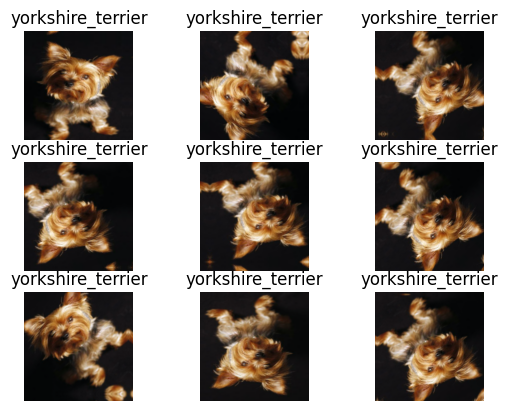

In [ ]:
for image, label in ds_train.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    aug_img = img_augmentation(tf.expand_dims(image, axis=0))
    aug_img = np.array(aug_img)
    plt.imshow(aug_img[0].astype("uint8"))
    plt.title("{}".format(format_label(label)))
    plt.axis("off")

In [ ]:
# You will need some one hot encoding for the classes
def input_preprocess_train(image, label):
  image = img_augmentation(image)
  label = tf.one_hot(label, NUM_CLASSES)
  return image, label

def input_preprocess_test(image, label):
  label = tf.one_hot(label, NUM_CLASSES)
  return image, label

ds_train = ds_train.map(input_preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.batch(batch_size=BATCH_SIZE, drop_remainder=True)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.map(input_preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(batch_size=BATCH_SIZE, drop_remainder=True)

In [ ]:
# Checking the shape from train dataset
for images_batch, labels_batch in ds_train.take(1):
  print("Dimensi gambar dalam batch :", images_batch.shape)
  print("Dimensi label dalam batch :", labels_batch.shape)

Dimensi gambar dalam batch : (32, 224, 224, 3)
Dimensi label dalam batch : (32, 120)


In [ ]:
'''
Input images shape is (224, 224, 3)
and range(0, 255)
Normalization is included in the model

But actually is not necessary to train all the layers in the model.
You just need some layers for trained again specifically in your dataset
And training all layers will demanding so much results
'''
model = EfficientNetB0(
    include_top=True,
    weights=None,
    classes=NUM_CLASSES,
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

epochs = 40
hist = model.fit(ds_train,
                 epochs=epochs,
                 validation_data=ds_test,
                 verbose=1)

Model: "efficientnetb0"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ cast (Cast)               │ (None, 224, 224, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 224, 224, 3)    │              0 │ cast[0][0]             │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 224, 224, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ normalization[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 4,203,291 (16.03 MB)

 Trainable params: 4,161,268 (15.87 MB)

 Non-trainable params: 42,023 (164.16 KB)

Epoch 1/40


KeyboardInterrupt: 

# Plotting learning curve
---

In [ ]:
def plot_hist(hist):
  plt.plot(hist.history["accuracy"])
  plt.plot(hist.history["val_accuracy"])
  plt.title("model accuracy")
  plt.ylabel("accuracy")
  plt.xlabel("epoch")
  plt.legend(['train', 'validation'], loc='upper left')
  plt.show()

plot_hist(hist)

## Building the model with transfer learning
---

In [ ]:
# Initialize the model with pre-trained EfficientNet weights. and fine tune it.
def build_model(num_classes):
  inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
  model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

  model.trainable = False

  x = layers.GlobalAveragePooling2D(name='avg_pool')(model.output)
  x = layers.BatchNormalization()(x)

  top_dropout_rate = 0.2
  x = layers.Dropout(top_dropout_rate, name='top_dropout')(x)
  outputs = layers.Dense(num_classes, activation='softmax', name='pred')(x)

  model = keras.Model(inputs, outputs, name="EfficientNet")
  optimizer = keras.optimizers.Adam(learning_rate=1e-2)

  model.compile(
      optimizer=optimizer,
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )
  return model

In [ ]:
'''
First step is Freeze all layers and only train the top layers.
We can using large learning rate for this step.
and prefer to validation accuracy caused of highly regularization.
'''
model = build_model(num_classes=NUM_CLASSES)

epochs = 10
hist = model.fit(ds_train,
                 epochs=epochs,
                 validation_data=ds_test,
                 verbose=1)
plot_hist(hist)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 259s 602ms/step - accuracy: 0.2876 - loss: 4.6234 - val_accuracy: 0.7986 - val_loss: 0.6523
Epoch 2/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 217s 577ms/step - accuracy: 0.5571 - loss: 1.7614 - val_accuracy: 0.8178 - val_loss: 0.5628
Epoch 3/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 216s 576ms/step - accuracy: 0.6113 - loss: 1.4533 - val_accuracy: 0.8317 - val_loss: 0.5113
Epoch 4/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 216s 574ms/step - accuracy: 0.6089 - loss: 1.4330 - val_accuracy: 0.8332 - val_loss: 0.5190
Epoch 5/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 216s 575ms/step - accuracy: 0.6202 - loss: 1.3908 - val_accuracy: 0.8449 - val_loss: 0.4845
Epoch 6/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 215s 573ms/step - accuracy: 0.6238 - loss: 1.3419 - val_accuracy: 0.8472 - val_loss: 0.4761
Epoch 7/25
375/375 ━━━━━━━━━━━━━━━━━━━━ 215s 574ms/step - accuracy: 0.6267 - loss: 1.3703 - val_accuracy: 0.8348 - val_loss: 0.5245
Epoch 8/25
375/375 ━━━━━━

In [ ]:
'''
Second Step
Unfreeze the number of layers and fit the model using smaller learning rate.
setting `trainable` of model will simultaneously set all layers belonging to Model
to same trainable attribute.

If the dataset is more different from ImageNet, fine tuning step is crucial.
'''
def unfreeze_model(model):
  for layer in model.layers:
    if not isinstance(layer, layers.BatchNormalization):
      layer.trainable = True

  optimizer = keras.optimizers.Adam(learning_rate=1e-5)
  model.compile(
      optimizer=optimizer,
      loss='categorical_crossentropy',
      metrics=['accuracy']
  )

unfreeze_model(model)

epochs = 4
hist = model.fit(ds_train,
                 validation_data=ds_test,
                 epochs=epochs,
                 verbose=1)
plot_hist(hist=hist)